# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from art.utils import load_cifar10
from art.attacks.evasion import GRAPHITEBlackbox
from art.estimators.classification import TensorFlowV2Classifier

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

In [9]:
cifar10_class_labels = ["airplane", "automobile", "bird", "cat", "deer",
                        "dog", "frog", "horse", "ship", "truck"]

# Model

In [3]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation="relu"),
    Dense(10)
])

In [4]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train 

In [5]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 7s 12ms/step - loss: 1.4364 - accuracy: 0.4833 - val_loss: 1.1288 - val_accuracy: 0.6011
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 0.9743 - accuracy: 0.6560 - val_loss: 0.9064 - val_accuracy: 0.6850
Epoch 3/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7625 - accuracy: 0.7328 - val_loss: 0.8584 - val_accuracy: 0.7051
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6024 - accuracy: 0.7904 - val_loss: 0.7547 - val_accuracy: 0.7390
Epoch 5/10
391/391 [==============================] - 4s 9ms/step - loss: 0.4593 - accuracy: 0.8407 - val_loss: 0.7986 - val_accuracy: 0.7414
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3196 - accuracy: 0.8885 - val_loss: 0.7742 - val_accuracy: 0.7574
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.1965 - accuracy: 0.9327 - val_loss: 0.9265 - val_accuracy: 0.7505
E

In [24]:
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=CategoricalCrossentropy(from_logits=True),
    nb_classes=10,
    input_shape=(32, 32, 3),
    preprocessing=(0.5, 1),
    clip_values=(min_, max_)
)

# Attack

In [40]:
attack = GRAPHITEBlackbox(
    classifier=classifier, 
    noise_size=(32, 32), 
    net_size=(32, 32), 
    heat_patch_size=(4, 4),
    heatmap_mode = 'Target',
)

In [41]:
x_adv = attack.generate(
    x=x_test[1, :, :, :][np.newaxis, :, :, :], 
    y=y_test[8][np.newaxis, :], 
    mask=None, 
    x_tar=x_test[8, :, :, :][np.newaxis, :, :, :]
)

# Results

In [42]:
y_pred = model.predict(x_test[1, :, :, :][np.newaxis, :, :, :], verbose=0)
y_pred = np.argmax(y_pred)
y_pred = cifar10_class_labels[y_pred]

In [43]:
adv_pred = model.predict(x_adv[0, :, :, :][np.newaxis, :, :, :], verbose=0)
adv_pred = np.argmax(adv_pred)
adv_pred = cifar10_class_labels[adv_pred]

In [44]:
print("Original Image Prediction:", y_pred)
print("Adversarial Image Prediction:", adv_pred)

Original Image Prediction: ship
Adversarial Image Prediction: automobile


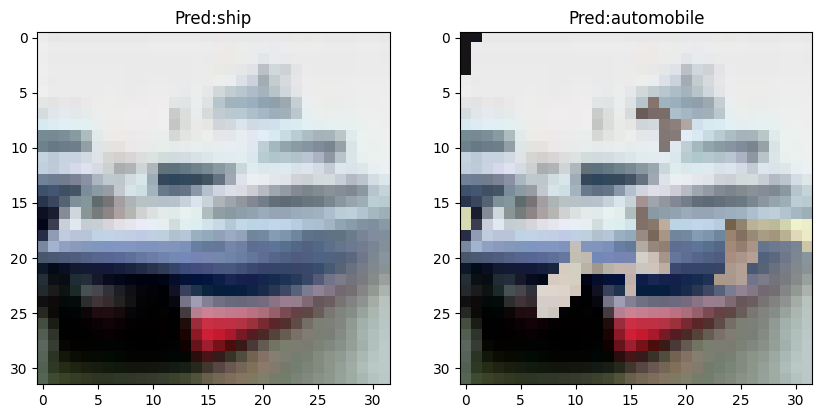

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

axes[0].imshow(x_test[1])
axes[0].set_title("Pred:" + y_pred)

axes[1].imshow(x_adv[0])
axes[1].set_title("Pred:" + adv_pred)

plt.show()